^C



EnvironmentNameNotFound: Could not find conda environment: py310
You can list all discoverable environments with `conda info --envs`.




Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: 'tensorflow=2.10'
Hint: = is not a valid operator. Did you mean == ?


In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# install adversarial-robustness-toolbox
!pip install adversarial-robustness-toolbox


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd
import tensorflow as tf


In [13]:
# Import ART dependencies as art
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset



ModuleNotFoundError: No module named 'art'

In [3]:
np.random.seed(0)

## Impoting Data

In [15]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Updating files: 100% (4/4)
Updating files: 100% (4/4), done.


In [4]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

## Data Visualisation

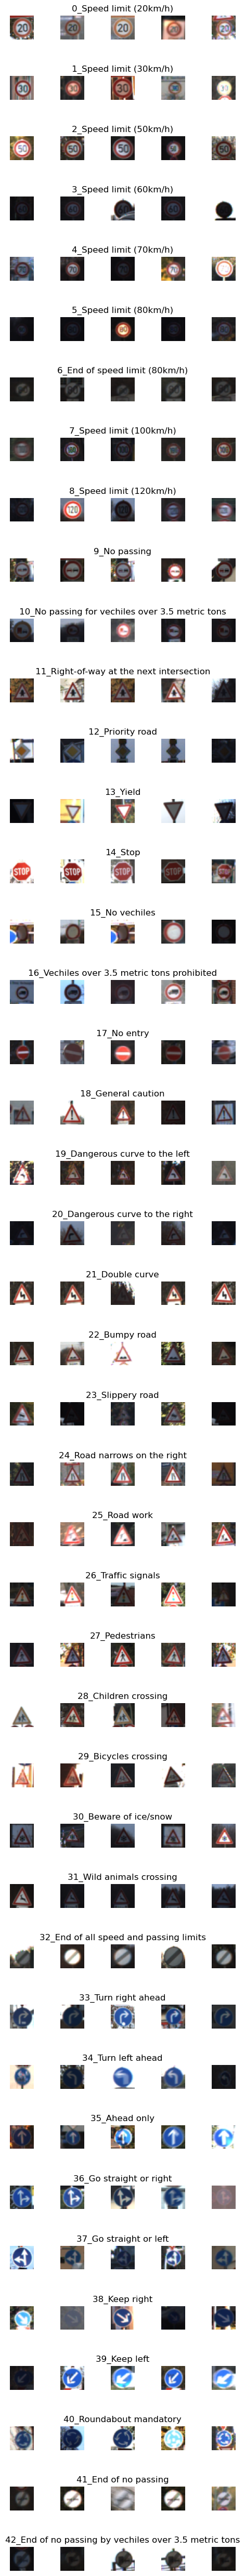

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))




In [1]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

NameError: name 'num_of_samples' is not defined

## Data Preprocessing

(32, 32, 3)
36


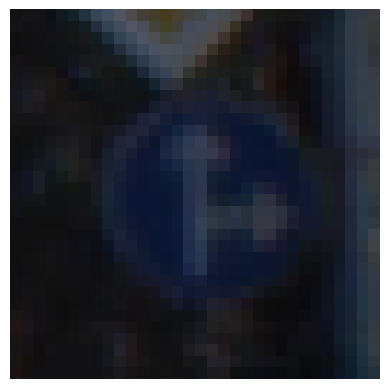

In [11]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [12]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


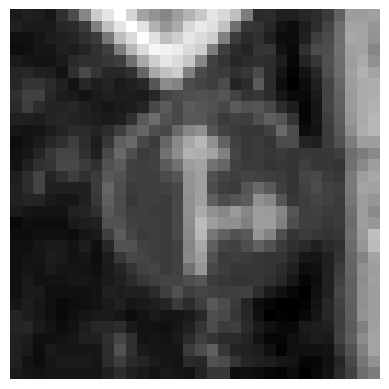

In [13]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [14]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


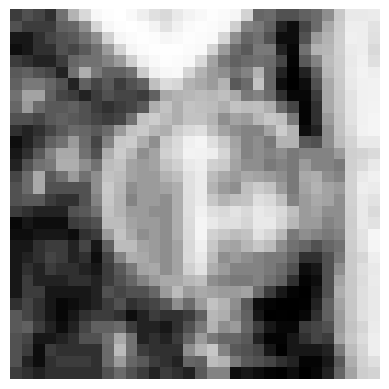

In [15]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [16]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

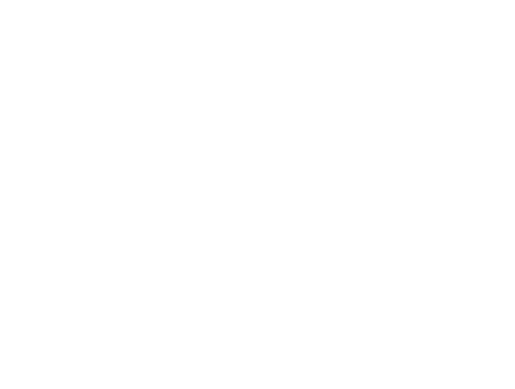

In [17]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [18]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

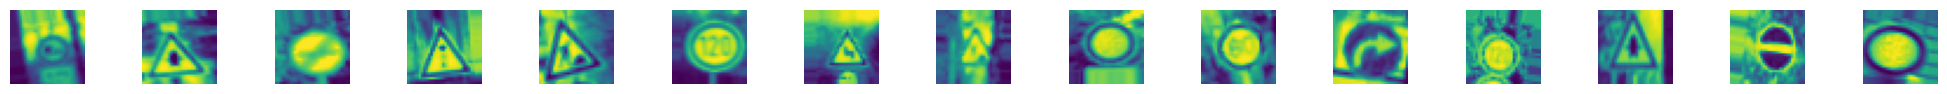

In [20]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')



In [21]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## Neural Network

In [22]:

def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model =neural_model()
print(model.summary())



C:\Users\mosta\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
steps_per_epoch = len(X_train) // 50

# Adjust steps per epoch if there are remaining samples
if len(X_train) % 50 != 0:
    steps_per_epoch += 1

print(steps_per_epoch)

696


In [24]:
history = model.fit(X_train, y_train, batch_size=50, epochs=10, steps_per_epoch=steps_per_epoch,validation_data=(X_val, y_val), shuffle=True)


Epoch 1/10


696/696 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.5245 - loss: 1.7529 - val_accuracy: 0.9463 - val_loss: 0.1729
Epoch 2/10


c:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9463 - val_loss: 0.1729
Epoch 3/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.9527 - loss: 0.1542 - val_accuracy: 0.9619 - val_loss: 0.1277
Epoch 4/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9619 - val_loss: 0.1277
Epoch 5/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.9735 - loss: 0.0862 - val_accuracy: 0.9732 - val_loss: 0.1052
Epoch 6/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9732 - val_loss: 0.1052
Epoch 7/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.9790 - loss: 0.0650 - val_accuracy: 0.9703 - val_loss: 0.0990
Epoch 8/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9703 - val_loss: 0.0990
Epoch 9/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9830 - lo

Text(0.5, 0, 'epoch')

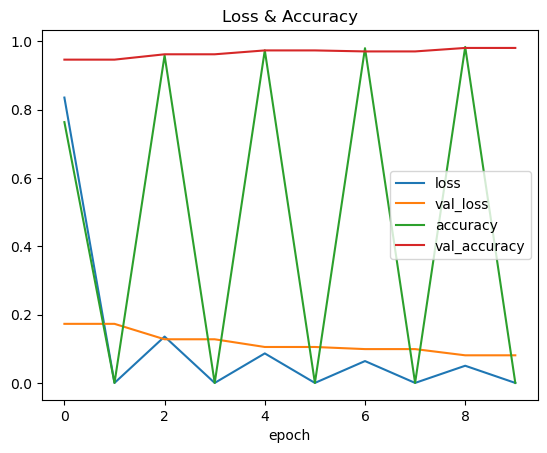

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])  # Corrected key
plt.plot(history.history['val_accuracy'])  # Corrected key
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])  # Corrected legend labels

plt.title('Loss & Accuracy')
plt.xlabel('epoch')
# colab free session  specs
# confusion matrix
# cut the rectangle and bulb

In [36]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9549 - loss: 0.2061
Test Score 0.21179504692554474
Test Accuracy 0.9535233378410339


## Testing

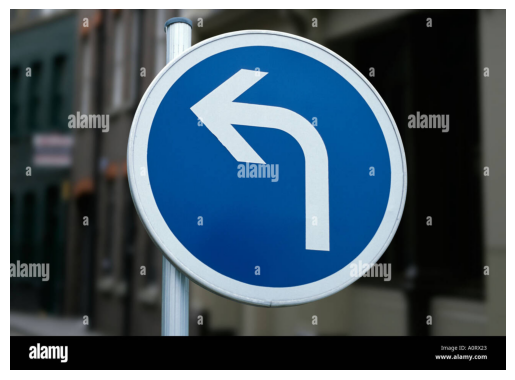

In [37]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

In [40]:
keras.saving.save_model(model, '')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=.

(32, 32)


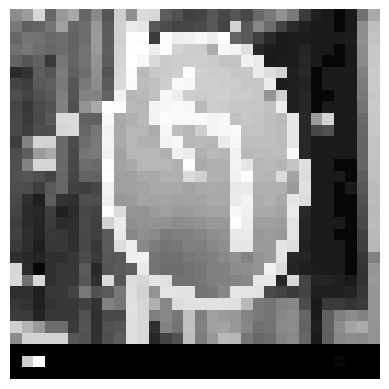

In [29]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [30]:
# Get the model's predictions for the image
predictions = model.predict(img)

# Get the index of the class with the highest probability for the image
predicted_class_index = np.argmax(predictions)

# Retrieve the sign name corresponding to the predicted class index
predicted_sign_name = data.iloc[predicted_class_index]['SignName']

print("Predicted sign: " + predicted_sign_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted sign: Right-of-way at the next intersection


In [31]:
# Get predictions for the image
predictions = model.predict(img)

# Find the index of the class with the highest probability
predicted_class_index = np.argmax(predictions)

# Convert the predicted class index to an integer
prediction = int(predicted_class_index)

# Print the prediction
print("Predicted class index:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class index: 11


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


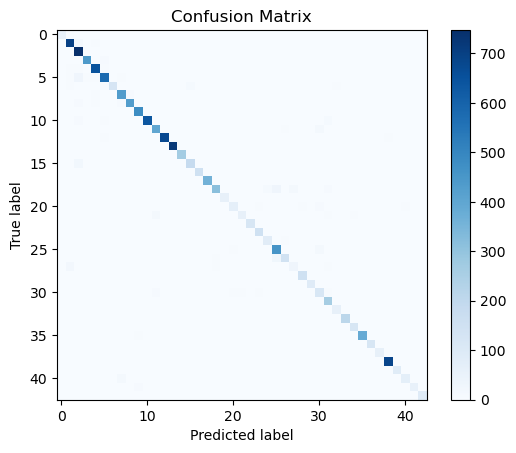

In [32]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


#Defense

#white box attacks


In [33]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier


loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(
    clip_values=(0, 1),
    model=model,
    nb_classes=10,
    input_shape=(32, 32, 1),  # Change this to match your model's input shape
    loss_object=loss_object,
)

In [34]:
from art.attacks.evasion import GRAPHITEBlackbox

attack = GRAPHITEBlackbox(classifier=classifier, max_iter=100, binary_search_steps=10, learning_rate=1e-2, initial_const=1e-3, max_halving=20, max_doubling=5, batch_size=1, verbose=True)


TypeError: GRAPHITEBlackbox.__init__() got an unexpected keyword argument 'max_iter'

In [ ]:
# save the model 
history

NameError: name 'history' is not defined

In [ ]:
test_images_adv = attack_fgsm.generate(x=X_test)

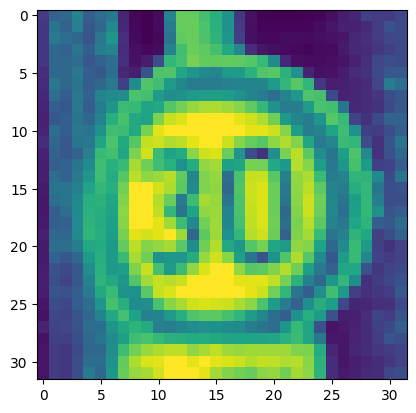

In [ ]:
plt.imshow(X_test[1].squeeze())

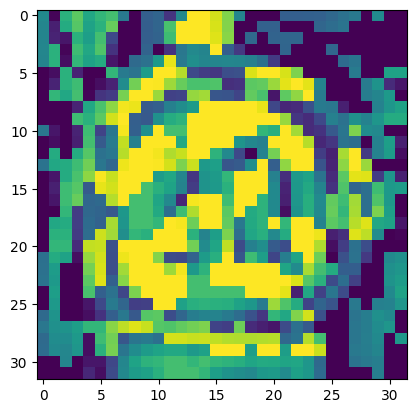

In [ ]:
plt.imshow(test_images_adv[1].squeeze())

In [ ]:
test_images=X_test
test_labels = y_test



In [ ]:
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

395/395 [==============================] - 1s 3ms/step - loss: 19.4390 - accuracy: 0.0432
Clean test set loss: 0.20 vs adversarial set test loss: 19.44
Clean test set accuracy: 0.95 vs adversarial test set accuracy: 0.04


1/1 [==============================] - 0s 17ms/step


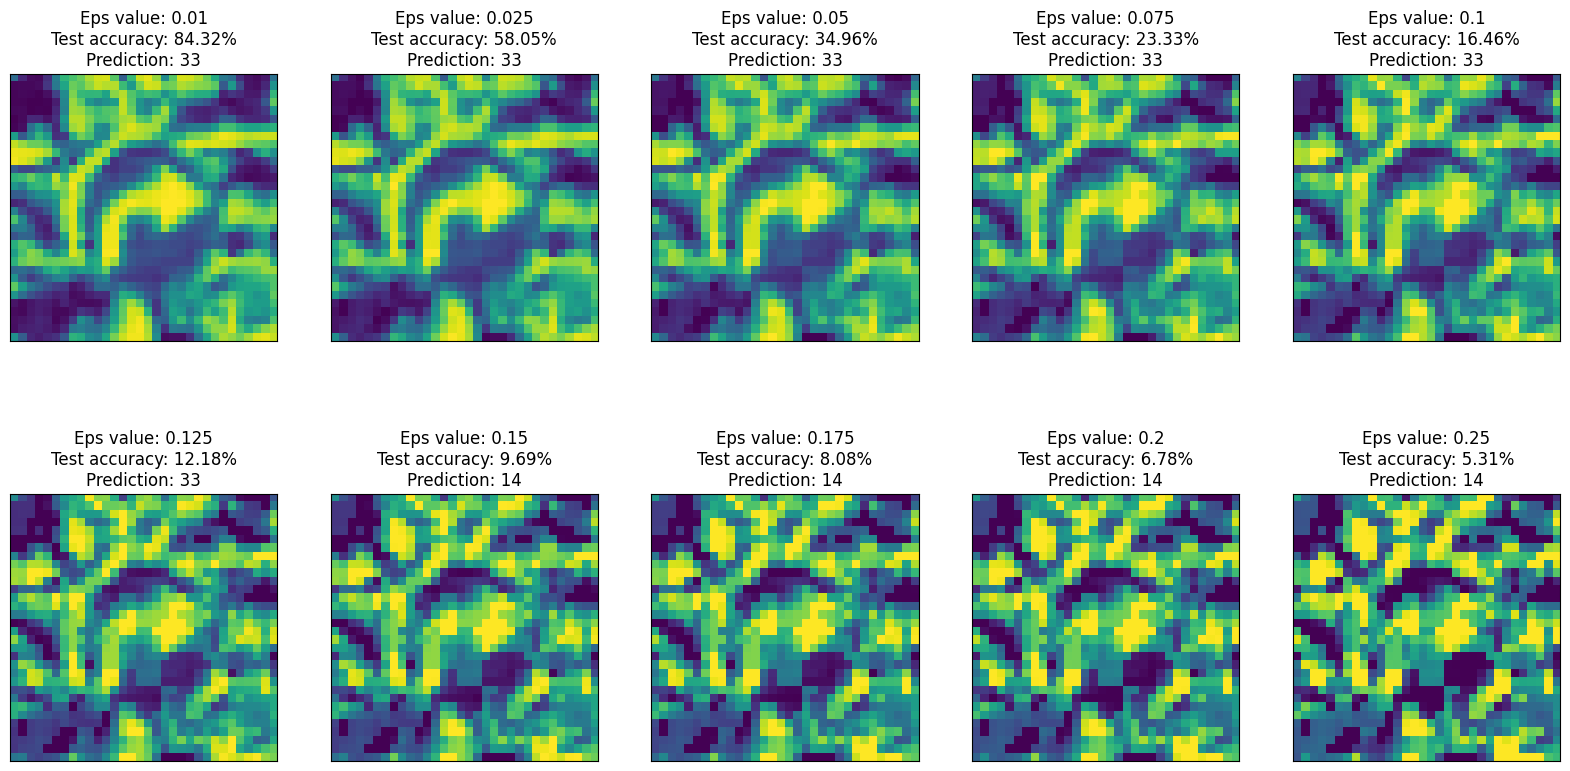

In [ ]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5
photo=3

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[photo].squeeze())

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[photo],
            axis=0)
            ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()